In [1]:
pip install pandahouse

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
connection_test = dict(database='test',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student-rw',
                  password='656e2b0c9c')

In [4]:
q = '''
    SELECT 
        UserID 
    FROM 
        {db}.checks 
    LIMIT 10
    '''

In [5]:
# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,UserID
0,18446583642950580515
1,18446535622689003675
2,18446130411954852964
3,18446003252714243011
4,18445948434655311802
5,18445927732647659917
6,18445761122620052505
7,18445655133428855896
8,18445587876544434519
9,18445586451093345117


In [8]:
q1 = """
CREATE TABLE test.example_table_1 (
    id UInt32,
    supplementary_id UInt32,
    comments String 
) 
ENGINE = MergeTree 
ORDER BY (id, supplementary_id)
"""


In [9]:
ph.execute(query=q1, connection=connection_test)

b''

In [12]:
df = pd.DataFrame({'a' : [1, 2, 3], 'b' : [0.6, 8, 5.4]})

In [14]:
# записываем данные из pandas в clickhouse
#ph.to_clickhouse(df, 'medium', index=False, connection=connection_test)

## Таблица ldn_listings:

In [15]:
qq = '''
    SELECT 
        count(*) 
    FROM 
        {db}.ldn_listings 
    '''

In [16]:
q_df = ph.read_clickhouse(query=qq, connection=connection_default)
q_df

,count()
0,85207


In [19]:
query_room = '''
    select 
        room_type, 
         toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    from {db}.ldn_listings
    order by id
    limit 1000
'''

In [20]:
room_price = ph.read_clickhouse(query=query_room, connection=connection_default)
room_price

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [21]:
room_price.dtypes

room_type     object
price        float32
dtype: object

In [22]:
room_price.groupby('room_type', as_index=False).quantile(q=0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [23]:
query_rating = '''
    select 
        room_type, 
         toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
         toFloat32OrNull(review_scores_rating) as review_scores_rating
    from {db}.ldn_listings
    where review_scores_rating is not Null
    order by id
    limit 1000
'''

In [24]:
rating = ph.read_clickhouse(query=query_rating, connection=connection_default)
rating

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [25]:
rating.dtypes

room_type                object
price                   float32
review_scores_rating    float32
dtype: object

In [27]:
x = rating.groupby('room_type', as_index=False).agg({'price' : 'mean'})
x

,room_type,price
0,Entire home/apt,135.882950
1,Hotel room,134.000000
2,Private room,54.642437
3,Shared room,21.000000


In [28]:
y = rating.groupby('room_type', as_index=False).agg({'review_scores_rating' : 'mean'})
y

,room_type,review_scores_rating
0,Entire home/apt,93.568787
1,Hotel room,92.500000
2,Private room,94.766205
3,Shared room,90.000000


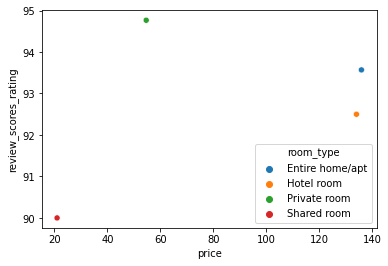

In [29]:
sns.scatterplot(x=x['price'], y=y['review_scores_rating'], hue=x['room_type'])

In [30]:
query_experience = '''
    select 
        distinct host_id, 
        host_verifications
    from {db}.ldn_listings
    where experiences_offered != 'none'
'''

In [39]:
exp = ph.read_clickhouse(query=query_experience, connection=connection_default)
exp

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [49]:
exp['host_verifications'] = exp['host_verifications'] \
                            .str.replace('[' , '') \
                            .str.replace(']' , '') \
                            .str.replace("'" , '') \
                            .str.split(', ')
exp

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."
...,...,...
1356,21558962,"[email, phone, reviews, jumio, government_id]"
1357,21257846,"[email, phone, reviews, jumio, offline_governm..."
1358,34219613,"[email, phone, reviews, jumio, government_id]"
1359,34299581,"[email, phone, google, reviews, jumio, offline..."


In [50]:
exp.explode('host_verifications').host_verifications.value_counts().to_frame(name='count')

,count
phone,1361
email,1345
reviews,1309
government_id,1196
jumio,1115
offline_government_id,469
work_email,279
facebook,270
selfie,252
identity_manual,227


In [51]:
query_count = '''
    select 
        neighbourhood_cleansed, 
        experiences_offered,
        count(distinct id) as experiences_count 
    from {db}.ldn_listings
    where experiences_offered != 'none'
    group by neighbourhood_cleansed, experiences_offered
    order by experiences_count desc
    limit 100
'''

In [52]:
piv_table = ph.read_clickhouse(query=query_count, connection=connection_default)
piv_table

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [54]:
v = piv_table.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
v

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


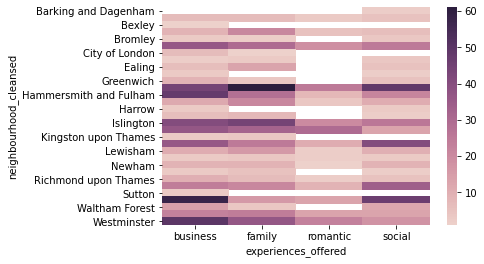

In [55]:
sns.heatmap(v, cmap=sns.cubehelix_palette(as_cmap=True))

In [56]:
query_price = '''
    select 
        room_type, 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr 
    from {db}.ldn_listings
    where experiences_offered != 'none'
'''

In [57]:
prix = ph.read_clickhouse(query=query_price, connection=connection_default)
prix

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


room_type
Entire home/apt    AxesSubplot(0.125,0.125;0.775x0.755)
Hotel room         AxesSubplot(0.125,0.125;0.775x0.755)
Private room       AxesSubplot(0.125,0.125;0.775x0.755)
Shared room        AxesSubplot(0.125,0.125;0.775x0.755)
Name: price_corr, dtype: object

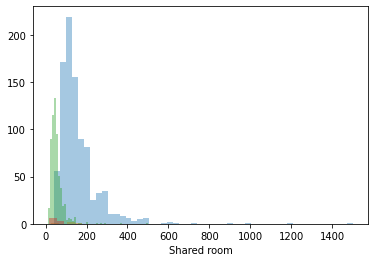

In [66]:
prix.groupby('room_type')['price_corr'].apply(sns.distplot, rug=False, kde=False)
#sns.distplot(np.log(prix.price_corr))

room_type
Entire home/apt    AxesSubplot(0.125,0.125;0.775x0.755)
Hotel room         AxesSubplot(0.125,0.125;0.775x0.755)
Private room       AxesSubplot(0.125,0.125;0.775x0.755)
Shared room        AxesSubplot(0.125,0.125;0.775x0.755)
Name: price_corr_log, dtype: object

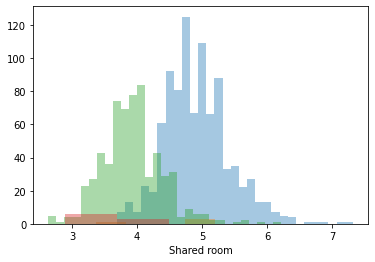

In [68]:
prix['price_corr_log'] = np.log(prix['price_corr'])
prix.groupby('room_type')['price_corr_log'].apply(sns.distplot, rug=False, kde=False)

In [80]:
query_review = '''
    select 
        room_type, 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr,
        first_review
    from {db}.ldn_listings
    where first_review > '2010-01-01'
    limit 1000
'''

In [81]:
rev = ph.read_clickhouse(query=query_review, connection=connection_default)
rev

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [82]:
rev.dtypes

room_type        object
price_corr      float32
first_review     object
dtype: object

In [83]:
rev['first_review'] = pd.to_datetime(rev.first_review)

In [84]:
rev.dtypes

room_type               object
price_corr             float32
first_review    datetime64[ns]
dtype: object

In [85]:
rev['year'] = rev.first_review.dt.year
rev

,room_type,price_corr,first_review,year
0,Private room,65.0,2010-08-18,2010
1,Entire home/apt,300.0,2011-03-21,2011
2,Entire home/apt,65.0,2016-03-05,2016
3,Private room,29.0,2010-04-14,2010
4,Private room,100.0,2010-10-16,2010
...,...,...,...,...
995,Private room,45.0,2012-11-07,2012
996,Private room,51.0,2013-03-18,2013
997,Entire home/apt,79.0,2012-09-17,2012
998,Entire home/apt,110.0,2012-09-24,2012


In [87]:
gr = rev.groupby(['room_type', 'year'], as_index=False).agg({'price_corr' : 'mean'})
gr

,room_type,year,price_corr
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328
5,Entire home/apt,2015,159.380951
6,Entire home/apt,2016,99.733330
7,Entire home/apt,2017,111.666664
8,Entire home/apt,2018,125.066666
9,Entire home/apt,2019,301.666656


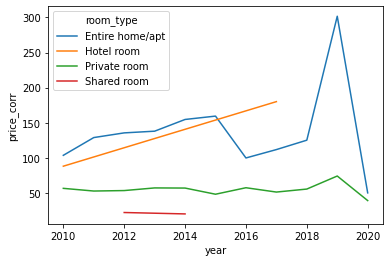

In [88]:
sns.lineplot(data=gr, x="year", y="price_corr", hue='room_type')